In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

from tqdm import tqdm
import pickle
#import h5py
import time

import numpy as np
import healpy as hp
#import scipy.interpolate as interpolate
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import jax.numpy as jnp
#from jax import jit, vmap

from utils.units_constants import *
from utils.geometry import *
from utils.spectral import *
from utils.nfw import *
from utils.map_utils import *
from utils.snr import *
from utils.telescopes import CHIME, CHIME_at_HIRAX, HIRAX_256, HIRAX_1024

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

## config

In [5]:
telescope = CHIME

freq_arr = np.linspace(telescope.nu_min, telescope.nu_max, 30) # [MHz]
    
field_model = 'JF' # {'AH', 'BH', 'JF'}
n_ra_grid_shift, n_dec_grid_shift = 5, 5 # set to 1, 1 to turn off

level = 2 # 0: naive gegenschein, 1: 3D modification, 2: with SNR

snr_front_gegenschein = True
modify_snr_bkg_mode = '' # 'add', 'replace', '' (off).
snr_vflag = 'none' # {'none', 'tiop1', 'tMFA_p', 'tMFA_m', 'd_p', 'd_m', 'age_p', 'age_m'}

verbose = 0 # 0: nothing, 1: info, 2: debug
SAVE_DIR = '../data/estimates'

run_name = '' # set to '' to be automatic

#========== end config ==========

if run_name == '':
    if level == 0:
        run_name = 'naive_gegenschein'
    elif level == 1:
        run_name = f'field_{field_model}'
    elif level == 2:
        run_name = f'field_{field_model}_snr'
        if snr_front_gegenschein:
            run_name += '_fg'
        if modify_snr_bkg_mode != '':
            run_name += '_snrbkg_' + modify_snr_bkg_mode
        if snr_vflag != 'none':
            run_name += f'_vf{snr_vflag}'
    else:
        raise ValueError('level too high')
    run_name = telescope.name + '/' + run_name
    
print('run_name :', run_name)

run_name : CHIME/field_JF_snr_fg


## 1. run

In [6]:
## pre-loop
tot_SNR_arr = np.zeros((len(freq_arr), n_ra_grid_shift, n_dec_grid_shift))

## loop
for i_freq, freq in enumerate(tqdm(freq_arr)):

    #========== Map grid ==========
    def ra_pixel_size(ra): # [rad]
        return (c0 / freq) / telescope.size_ra
    def dec_pixel_size(dec): # [rad]
        return (c0 / freq) / telescope.size_dec * np.cos(dec - telescope.dec)

    #---------- grid shift ----------
    ra_mid = np.pi
    dec_mid = telescope.dec
    ra_grid_shift_step = ra_pixel_size(ra_mid) / n_ra_grid_shift
    dec_grid_shift_step = dec_pixel_size(dec_mid) / n_dec_grid_shift
    ra_shifted_mids = ra_mid + np.arange(n_ra_grid_shift) * ra_grid_shift_step
    dec_shifted_mids = dec_mid + np.arange(n_dec_grid_shift) * dec_grid_shift_step
    
    for i_ra_sh, ra_shifted_mid in enumerate(ra_shifted_mids):
        for i_dec_sh, dec_shifted_mid in enumerate(dec_shifted_mids):
            ra_edges = np.array(
                grid_edges(ra_pixel_size, telescope.ra_min, telescope.ra_max, a_mid=ra_shifted_mid)
            )
            dec_edges = np.array(
                grid_edges(dec_pixel_size, telescope.dec_min, telescope.dec_max, a_mid=dec_shifted_mid)
            )
            ra_s  = (ra_edges[:-1]  + ra_edges[1:] ) / 2
            dec_s = (dec_edges[:-1] + dec_edges[1:]) / 2
            ra_grid, dec_grid = np.meshgrid(ra_s, dec_s)
            radec_flat = np.stack([ra_grid.ravel(), dec_grid.ravel()], axis=-1)
            radec_shape = (len(dec_s), len(ra_s))

            coord_grid = SkyCoord(ra=ra_grid*u.rad, dec=dec_grid*u.rad, frame='icrs')
            l_grid = np.array(coord_grid.galactic.l.rad)
            b_grid = np.array(coord_grid.galactic.b.rad)
            lb_flat = np.stack([l_grid.ravel(), b_grid.ravel()], axis=-1)

            anti_l_grid = l_grid + np.pi
            anti_l_grid = np.where(anti_l_grid > 2*np.pi, anti_l_grid - 2*np.pi, anti_l_grid)
            anti_b_grid = - b_grid
            anti_lb_flat = np.stack([anti_l_grid.ravel(), anti_b_grid.ravel()], axis=-1)

            #========== Source (Haslam) map ==========
            nu_haslam = 408 # [MHz]
            beta = -2.55
            # destriped desourced
            haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
            haslam_dsds_map_hp *= (freq/nu_haslam) ** beta
            haslam_dsds_map = hp.pixelfunc.get_interp_val(
                haslam_dsds_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
            )
            # destriped
            haslam_ds_map_hp = hp.read_map('../data/haslam_maps/haslam408_ds_Remazeilles2014.fits')
            haslam_ds_map_hp *= (freq/nu_haslam) ** beta
            haslam_ds_map = hp.pixelfunc.get_interp_val(
                haslam_ds_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
            )

            #========== DM column integral ==========
            rho_integral_map = rho_integral(lb_flat).reshape(radec_shape)

            #========== Naive gegenschein / reference forwardschein temperature ==========
            haslam_anti_dsds_map = hp.pixelfunc.get_interp_val(
                haslam_dsds_map_hp, anti_l_grid/deg, anti_b_grid/deg, lonlat=True
            )
            gegen_temp_map = prefac(freq) * haslam_anti_dsds_map * rho_integral_map # naive gegenschein
            forward_temp_map = prefac(freq) * haslam_dsds_map * rho_integral_ref
            # reference forward+front temperature # I_src * 10kpc uniform column with rho_NFW(r_Sun)

            #========== Exposure ==========
            ra_beam_size = (c0 / freq) / telescope.primary_beam_baseline
            sec_in_day = 86400 # [s]
            exposure_map = sec_in_day / (2*np.pi / ra_beam_size)
            if telescope.double_pass_dec is not None:
                exposure_map *= ((dec_grid > telescope.double_pass_dec) + 1)

            #========== Naive S/N ==========
            sig_temp_map = gegen_temp_map
            T_sys = telescope.T_sys(freq) if callable(telescope.T_sys) else telescope.T_sys
            eta   = telescope.eta(freq)   if callable(telescope.eta)   else telescope.eta
            bkg_temp_map = haslam_ds_map + T_sys / eta # [K/eta]
            SNR_map = sig_temp_map / bkg_temp_map * np.sqrt(
                2 * dnu(freq) * 1e6 * exposure_map * telescope.t_obs_days
            )

            if level == 0: # naive gegenschein
                tot_SNR_arr[i_freq, i_ra_sh, i_dec_sh] = np.sqrt(np.sum(SNR_map**2))
                continue

            #========== S/N with modification according to 3D model ==========
            I_data = pickle.load(open(f'../data/galactic_models/I_data_{field_model}.dict', 'rb'))
            g_ratio_lr = I_data['focused'] / I_data['naive']
            f_ratio_lr = (I_data['front'] + I_data['forward']) / I_data['forward_ref']

            lb_flat_minuspi_to_pi = np.where(lb_flat > np.pi, lb_flat-2*np.pi, lb_flat)
            g_ratio = interpolate_padded(
                g_ratio_lr, I_data['l'], I_data['b'], lb_flat_minuspi_to_pi
            ).reshape(radec_shape)
            f_ratio = interpolate_padded(
                f_ratio_lr, I_data['l'], I_data['b'], lb_flat_minuspi_to_pi
            ).reshape(radec_shape)

            sig_temp_map = gegen_temp_map * g_ratio + forward_temp_map * f_ratio
            bkg_temp_map = haslam_ds_map + T_sys / eta

            if level == 1: # 3D modification
                SNR_map = (sig_temp_map / bkg_temp_map) * np.sqrt(
                    2 * dnu(freq) * 1e6 * exposure_map * telescope.t_obs_days
                )
                tot_SNR_arr[i_freq, i_ra_sh, i_dec_sh] = np.sqrt(np.sum(SNR_map**2))
                continue

            #========== Add snr to map ==========
            sig_temp_map_snr = np.array(sig_temp_map).copy()
            bkg_temp_map_snr = np.array(haslam_ds_map).copy()
            pixel_area_map = np.outer(
                (dec_edges[1:] - dec_edges[:-1]),
                (ra_edges[1:] - ra_edges[:-1])
            ) * np.cos(dec_s)[:,None] # [sr]
            snr_list = pickle.load(open(f'../data/SNR/snrlist_{snr_vflag}.p', 'rb'))
            n_sigma = 3
            use_gaussian_intg = True

            for snr in snr_list:
                snr_ra = snr.coord.icrs.ra.rad
                snr_dec = snr.coord.icrs.dec.rad
                snr_anti_ra  = snr_ra + np.pi if snr_ra < np.pi else snr_ra - np.pi
                snr_anti_dec = - snr_dec

                #---------- Gegenschein ----------
                #T_submap = snr.Sgnu(freq)*Jy * tmpl * c0**2 / (2 * freq**2 * pixel_area_submap * kb)
                T_submap_prefactor = snr.Sgnu(freq)*Jy * 1 * c0**2 / (2 * freq**2 * 1 * kb)
                # [K] = [MHz^2 g] [cm MHz]^2 [MHz]^-2 [cm^2 MHz^2 g K^-1]^-1
                add_image_to_map(
                    sig_temp_map_snr, ra_s, dec_s, ra_edges, dec_edges,
                    pixel_area_map,
                    source_ra = snr_anti_ra,
                    source_dec = snr_anti_dec,
                    image_sigma = snr.image_sigma, n_sigma=3,
                    T_submap_prefactor = T_submap_prefactor,
                    use_gaussian_intg=False, modify_mode='add'
                )

                #---------- Front gegenschein ----------
                if snr_front_gegenschein: # 
                    #T_submap = snr.Sgnu(freq)*Jy * tmpl * c0**2 / (2 * freq**2 * pixel_area_submap * kb)
                    T_submap_prefactor = snr.Sfgnu(freq)*Jy * 1 * c0**2 / (2 * freq**2 * 1 * kb)
                    # [K] = [MHz^2 g] [cm MHz]^2 [MHz]^-2 [cm^2 MHz^2 g K^-1]^-1
                    add_image_to_map(
                        sig_temp_map_snr, ra_s, dec_s, ra_edges, dec_edges,
                        pixel_area_map,
                        source_ra = snr_ra,
                        source_dec = snr_dec,
                        image_sigma = snr.image_sigma_fg, n_sigma=3,
                        T_submap_prefactor = T_submap_prefactor,
                        use_gaussian_intg=False, modify_mode='add'
                    )

                #---------- Modify bkg using snr information ----------
                if modify_snr_bkg_mode != '':
                    #T_submap = snr.Sgnu(freq)*Jy * tmpl * c0**2 / (2 * freq**2 * pixel_area_submap * kb)
                    T_submap_prefactor = snr.Snu(freq)*Jy * 1 * c0**2 / (2 * freq**2 * 1 * kb)
                    # [K] = [MHz^2 g] [cm MHz]^2 [MHz]^-2 [cm^2 MHz^2 g K^-1]^-1
                    add_image_to_map(
                        bkg_temp_map_snr, ra_s, dec_s, ra_edges, dec_edges,
                        pixel_area_map,
                        source_ra = snr_ra,
                        source_dec = snr_dec,
                        image_sigma = snr.size, n_sigma=3,
                        T_submap_prefactor = T_submap_prefactor,
                        use_gaussian_intg=False, modify_mode=modify_snr_bkg_mode, debug=False
                    )

            bkg_temp_map_snr += T_sys / eta

            if level >= 2: # snr
                SNR_map = (sig_temp_map_snr / bkg_temp_map_snr) * np.sqrt(
                    2 * dnu(freq) * 1e6 * exposure_map * telescope.t_obs_days
                )
                tot_SNR_arr[i_freq, i_ra_sh, i_dec_sh] = np.sqrt(np.sum(SNR_map**2))
                continue

            #========== Output ==========
            if verbose >= 1:
                print(f'freq = {freq:.3f} MHz, SNR = {tot_SNR:.6f}')

            if verbose >= 2:
                print('===== DEBUG =====')
                print('rho_integral_ref =', rho_integral_ref, '[g/cm^2]')
                print('naive gegenschein:', np.sqrt(np.sum(SNR_g_s**2)))
                print('reference forwardschein:', np.sqrt(np.sum(SNR_f_s**2)))
                print('=================')

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [14:03<00:00, 28.13s/it]


In [7]:
save_dict = {
    'freq' : freq_arr,
    'SNR' : np.mean(tot_SNR_arr, axis=(1, 2)),
    'SNR_arr'  : tot_SNR_arr,
}
fn = f'{SAVE_DIR}/{run_name}.p'
pickle.dump(save_dict, open(fn, 'wb'))

## WIP

### WIP.source

## 2. Intermediate plots

In [55]:
prefix = f'{SAVE_DIR}/plots_{run_name}'
os.makedirs(prefix, exist_ok=True)

Plot saved: ../data/estimates/plots_HIRAX-256/field_AH_snr_fg/pixel_grid.png


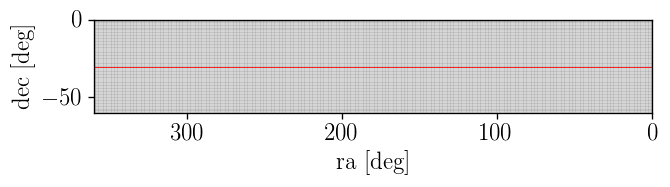

In [13]:
save_fn = f'{prefix}/pixel_grid.png'
fig, ax = plt.subplots()
for a in ra_edges[::10]:
    ax.axvline(np.rad2deg(a), color='k', lw=0.1)
for a in dec_edges[::10]:
    ax.axhline(np.rad2deg(a), color='k', lw=0.1)
ax.axhline(np.rad2deg(telescope.dec), color='r', lw=0.5)
ax.set(xlim=telescope.extent[:2], ylim=telescope.extent[2:4], aspect=1)
ax.set(xlabel='ra [deg]', ylabel='dec [deg]')
plt.savefig(save_fn)
print(f'Plot saved: {save_fn}')

Plot saved: ../data/estimates/plots_HIRAX-256/field_AH_snr_fg/haslam.png


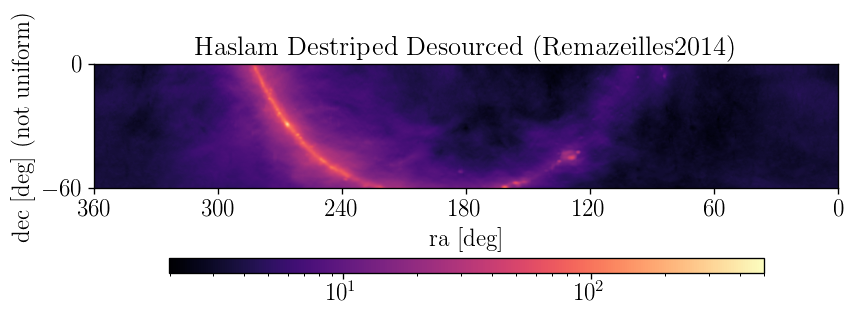

In [14]:
plot_radec(haslam_dsds_map, extent=telescope.extent, vmax=500,
           title=r'Haslam Destriped Desourced (Remazeilles2014)', cmap='magma',
           save_fn=f'{prefix}/haslam.png')

Plot saved: ../data/estimates/plots_HIRAX-256/field_AH_snr_fg/nfw.png


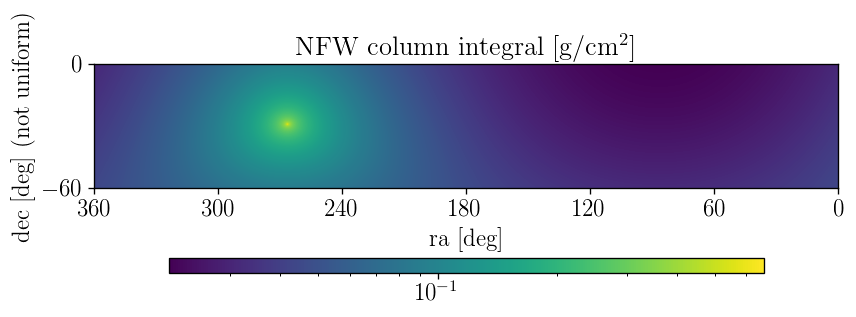

In [15]:
plot_radec(rho_integral_map, extent=telescope.extent,
           title=r'NFW column integral [g/cm$^2$]', cmap='viridis',
           save_fn=f'{prefix}/nfw.png')

Plot saved: ../data/estimates/plots_field_AH_snr/naive_gegenschein.png


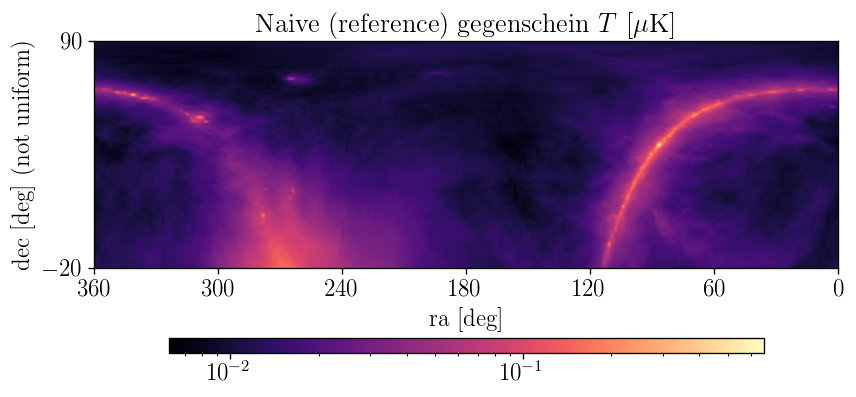

In [15]:
plot_radec(gegen_temp_map * 1e6, extent=telescope.extent,
           title=r'Naive (reference) gegenschein $T$ [$\mu$K]', cmap='magma',
           save_fn=f'{prefix}/naive_gegenschein.png')

Plot saved: ../data/estimates/plots_field_AH_snr/reference_forwardschein.png


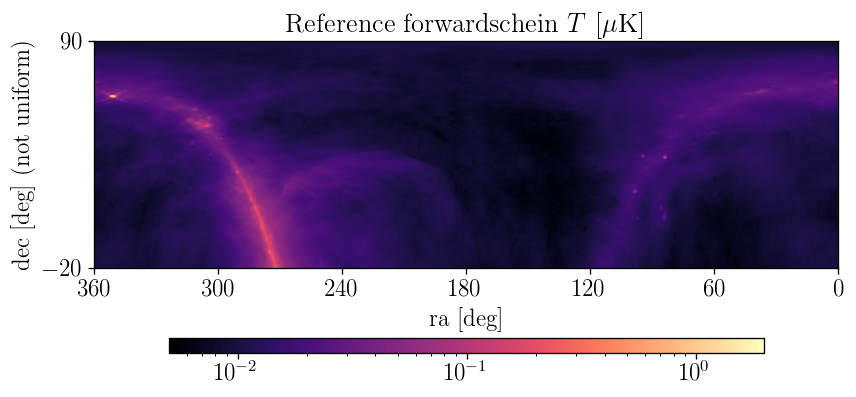

In [16]:
plot_radec(forward_temp_map * 1e6, extent=telescope.extent,
           title=r'Reference forwardschein $T$ [$\mu$K]', cmap='magma',
           save_fn=f'{prefix}/reference_forwardschein.png')

In [ ]:
plot_radec(exposure_map, extent=telescope.extent, log_norm=False,
           title='Daily exposure [s]', vmax=1200, vmin=0, cmap='viridis',
           save_fn=f'{prefix}/exposure.png')

Plot saved: ../data/estimates/plots_CHIME/field_AH_snr_fg/gegenschein_S_N.png


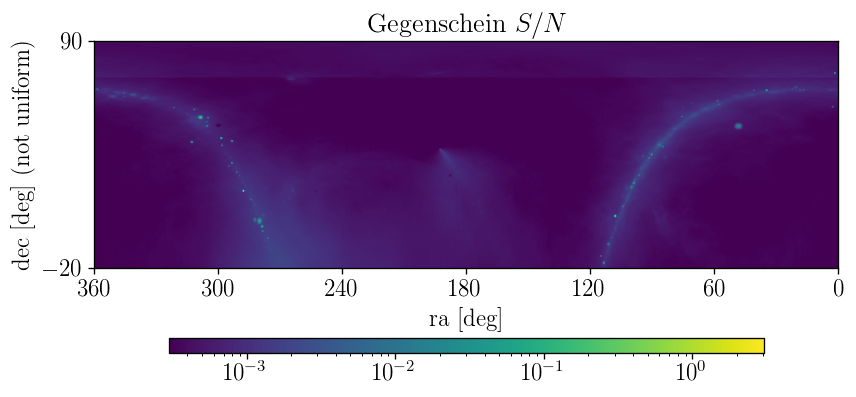

In [56]:
plot_radec(np.clip(SNR_map, 3e-4, None), extent=telescope.extent,
           title=r'Gegenschein $S/N$', cmap='viridis',
           save_fn=f'{prefix}/gegenschein_S_N.png')

Plot saved: ../data/estimates/plots_field_AH/dependence_pixels.png
Contribution to S/N:
all pixels:  0.59312904
pixels > 1e-2:  0.033539753
pixels 1e-3 ~ 1e-2:  0.44730407


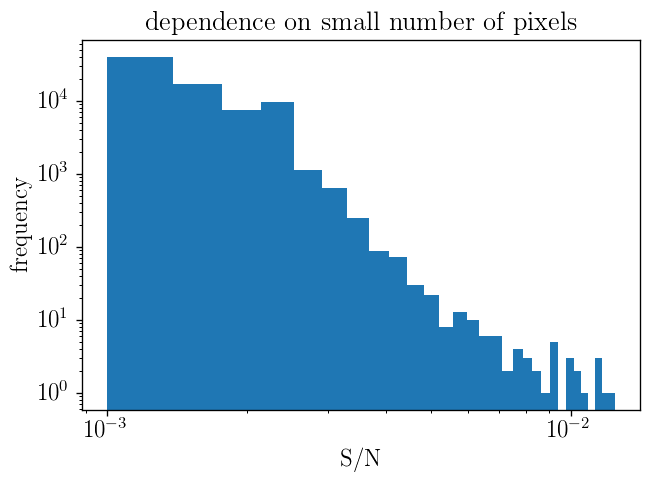

In [59]:
save_fn = f'{prefix}/dependence_pixels.png'
fig, ax = plt.subplots()
ax.hist(SNR_g_s[SNR_g_s>1e-3], bins=30)
ax.set(xscale='log', yscale='log')
ax.set(xlabel='S/N', ylabel='frequency',
       title='dependence on small number of pixels')
plt.savefig(save_fn)
print(f'Plot saved: {save_fn}')
print('Contribution to S/N:')
print('all pixels: ', np.sqrt(np.sum(SNR_g_s**2)))
print('pixels > 1e-2: ', np.sqrt(np.sum(SNR_g_s[SNR_g_s>1e-2]**2)))
print('pixels 1e-3 ~ 1e-2: ', np.sqrt(np.sum(SNR_g_s[np.logical_and(SNR_g_s>1e-3,SNR_g_s<1e-2)]**2)))

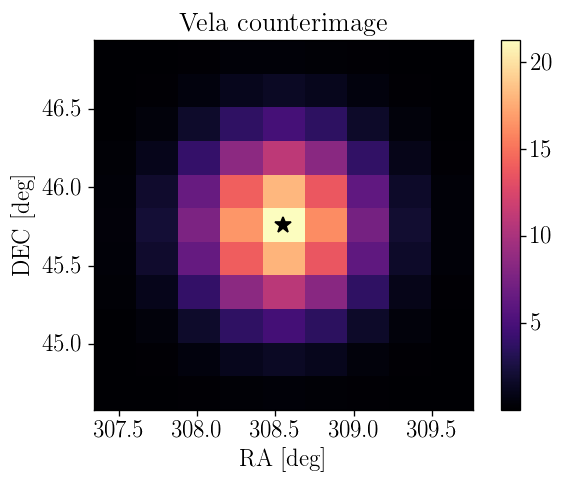

In [56]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.rad2deg(ra_subgrid), np.rad2deg(dec_subgrid), 1e6 * T_submap, cmap='magma')
ax.plot([np.rad2deg(snr_anti_ra)], [np.rad2deg(snr_anti_dec)], color='k', marker='*', ms=10)
ax.set(title=snr.name() + ' counterimage', xlabel='RA [deg]', ylabel='DEC [deg]', aspect=1)
fig.colorbar(im)

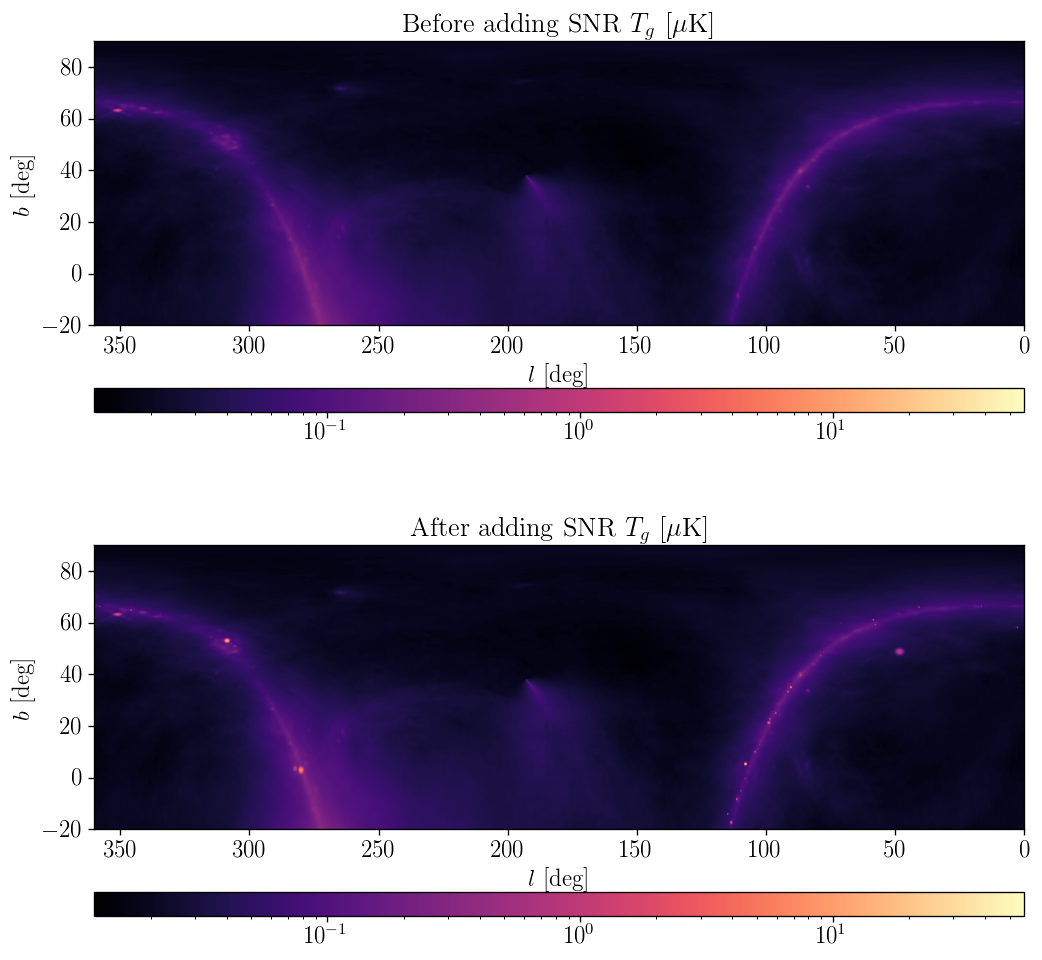

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

z0 = sig_temp_map * 1e6
z1 = sig_temp_map_snr * 1e6
im0 = axs[0].imshow(np.flip(z0), cmap='magma', extent=telescope.extent,
                    norm=mpl.colors.LogNorm(np.min(z1), np.max(z1)))
im1 = axs[1].imshow(np.flip(z1), cmap='magma', extent=telescope.extent,
                    norm=mpl.colors.LogNorm(np.min(z1), np.max(z1)))
axs[0].set(title=r'Before adding SNR $T_g$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(title=r'After adding SNR $T_g$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
fig.colorbar(im0, ax=axs[0], orientation='horizontal', aspect=40)
fig.colorbar(im1, ax=axs[1], orientation='horizontal', aspect=40);

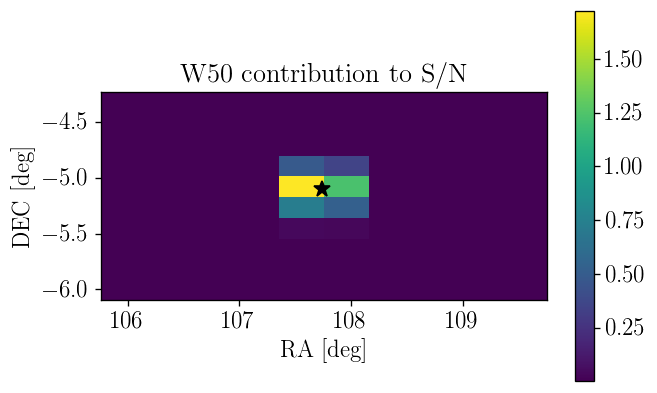

In [19]:
snr = get_snr('W50', snr_list)
snr_ra = snr.coord.icrs.ra.rad
snr_dec = snr.coord.icrs.dec.rad
snr_anti_ra  = snr_ra + np.pi if snr_ra < np.pi else snr_ra - np.pi
snr_anti_dec = - snr_dec
i_ra = np.searchsorted(ra_s, snr_anti_ra)
i_dec = np.searchsorted(dec_s, snr_anti_dec)

ra_subgrid, dec_subgrid = np.meshgrid(ra_s[i_ra-5:i_ra+5], dec_s[i_dec-5:i_dec+5])

fig, ax = plt.subplots()
im = ax.pcolormesh(np.rad2deg(ra_subgrid), np.rad2deg(dec_subgrid), SNR_map[i_dec-5:i_dec+5, i_ra-5:i_ra+5])
ax.plot([np.rad2deg(snr_anti_ra)], [np.rad2deg(snr_anti_dec)], color='k', marker='*', ms=10)
ax.set(title=snr.name() + ' contribution to S/N', xlabel='RA [deg]', ylabel='DEC [deg]', aspect=1)
fig.colorbar(im);

### 3.1 Make special plots

In [84]:
pickle.dump(SNR_map, open('../data/for_plots/1_CHIME_SNR_comp/SNR_map_fg.p', 'wb'))